<a href="https://colab.research.google.com/github/SEOYUNJE/Endoscope-Object-Detection/blob/main/Detectron2/ColonoScopy/Vit/Train/baseline_v1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opendatasets

import opendatasets as od
od.download('https://www.kaggle.com/datasets/msyu78/gastroscopy-meta')
od.download('https://www.kaggle.com/datasets/seoyunje/gastroscopy-256x256-resized-png')

Skipping, found downloaded files in "./gastroscopy-meta" (use force=True to force download)
Skipping, found downloaded files in "./gastroscopy-256x256-resized-png" (use force=True to force download)


## 1. Import Library
___

In [2]:
!pip install -q colorama

In [3]:
import os
import sys
import pickle
import random
import gc
import ctypes
import copy

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from colorama import Fore

from PIL import Image
import cv2

import torch

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

print(f'{Fore.GREEN}=> Installed Necessary Library')

=> Installed Necessary Library


### Configuration

In [4]:
class CFG:
    debug = False
    output_dir = 'runs/detect'
    seed = 42
    train_ds = 'gastroscopy_train'

    img_size = [256,256]
    input_format = 'RGB'
    imgdir = '/content/gastroscopy-256x256-resized-png'
    mapper_type = 'albu' # 'detectron2'

    split_mode = 'valid20'
    max_iter = 100 # default 40_000
    ims_per_batch = 8
    num_workers = 4

    lr_scheduler_name = 'WarmupCosineLR' # WarmupMultiStepLR
    base_lr = 1e-2 # default: 1e-3
    base_lr_end = 1e-11 # default: 0
    weight_decay = 1e-3 # default 1e-4
    warmup_factor = base_lr*0.1 # default: 1e-3
    warmup_iters = max_iter // 10 # default: 1_000
    eval_period = max_iter * 10
    amp = True # Auto Mixed Precision

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(CFG.output_dir, exist_ok=True)

### Reproducibility

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark= False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

### Clean_Memory

In [6]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()

clean_memory()

### Install Detectron Library

In [7]:
print(f'=> {Fore.GREEN}Installing Detectron2 Library...' )
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

## Or, to install it from a local clone:
# !git clone https://github.com/facebookresearch/detectron2.git
# !python -m pip install -e detectron2

=> Installing Detectron2 Library...
  Preparing metadata (setup.py) ... done


## 2. Build Dataset_Dicts
___

- **궤양**: `ulcer(label: 0)`

- **용종**: `polyp(label: 1)`

- **암**: `cancer(label: 2)`

In [8]:
meta_data = pd.read_csv('/content/gastroscopy-meta/gastroscopy_data2.csv')
print('Shape of DataFrame: ', meta_data.shape)
meta_data.head()

Shape of DataFrame:  (2915, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,763.829787,365.957447,1304.255319,748.936170,ulcer
1,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,1148.936170,897.872340,1421.276596,1082.978723,ulcer
2,1_1_00014.png,2048,2048,gastroscopy,0,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,521.276596,561.702128,1078.723404,1225.531915,ulcer
3,1_1_00017.png,2048,2048,gastroscopy,0,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,884.595745,502.127660,1376.085106,753.191489,ulcer
4,1_1_00018.png,2048,2048,gastroscopy,0,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,1161.191489,382.978723,1654.808511,1074.468085,ulcer


In [9]:
thing_classes = [
    'Ulcer',
    'Polyp',
    'Cancer',
]

category_id_to_name = {index: class_name for index,class_name in enumerate(thing_classes) }

meta_data['lesion'] = meta_data['lesion_label'].map(category_id_to_name)

In [10]:
train_id = [x.split('/')[-1] for x in glob('/content/gastroscopy-256x256-resized-png/train/*.png')]
test_id = [x.split('/')[-1] for x in glob('/content/gastroscopy-256x256-resized-png/test/*.png')]

train_df = meta_data[meta_data['image_id'].isin(train_id)].reset_index(drop=True)
test_df = meta_data[meta_data['image_id'].isin(test_id)].reset_index(drop=True)

print('=> Number of Unique Image_id in Train: ', train_df.image_id.nunique())
print('=> Number of Unique Image_id in Test: ', test_df.image_id.nunique())

=> Number of Unique Image_id in Train:  1597
=> Number of Unique Image_id in Test:  400


### Dectectron2 Library Dataset Format

![image.png](attachment:642bd6d2-f1b9-4598-84e2-85040eb9fac1.png)


<div style="border-radius:10px; border:#000000 solid; padding: 15px; font-size:100%;">


📌 **`dataset_dicts`**: Metadata of Image, in Detectron2 Dataset Format

To define custom datasets, we need to create list of dict(`dataset_dicts`) where each dict contains following:

- `file_name`: file name of the image
- `image_id`: id of the image, index is used here.
- `height`: height of the image
- `width`: width of the image
- `annotation`: This the ground truth annotation data for object detection, which contains following:
  - `bbox`: bounding box pixel location with shape(n_boxes, 4)
  - `bbox_mode`: BoxMode.XYXY_ABS meaning that absolute value of (xmin, ymin, xmax, ymax)
  - `category_id`: class label id for each bounding box, with shape(n_boxes,)


### Define Dataset_dicts

In [11]:
from detectron2.structures import BoxMode

def get_gastroscopy_dicts(
    imgdir: str,
    df,
    mode: str = 'train',
    use_cache: bool = True,
    debug: bool = True,
    target_indices: list = None
):
    debug_str = f"_debug{int(debug)}"
    cache_path = f'/content/dataset_dicts_cache_{mode}{debug_str}.pkl'

    if not use_cache or not os.path.exists(cache_path):
       print(f'{Fore.BLUE}#'* 25)
       print(f'### Creating {mode} Data...')
       print('#' * 25)

       meta_df = pd.read_csv(f'/content/gastroscopy-256x256-resized-png/{mode}_meta.csv')

       if debug:
           meta_df = meta_df[:500]

       image_id = meta_df.loc[0,'image_id']
       image_path = os.path.join(imgdir,mode, image_id)
       image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
       resized_height, resized_width, channel = image.shape
       print(f'=> Height of Image: {resized_height}')
       print(f'=> Width of Image: {resized_width}')

       dataset_dicts = []
       for _, (image_id, height, width) in tqdm(meta_df.iterrows(), total=len(meta_df), desc='Build Dataset Dict'):
           record = {}
           record['file_name'] = os.path.join(imgdir,'train',image_id)
           record['image_id'] = image_id
           record['height'] = resized_height
           record['width'] = resized_width

           if mode != 'test':
              objs = []
              for _, row in df[df.image_id == image_id].iterrows():
                  class_id = row['lesion_label']

                  h_ratio = resized_height / height
                  w_ratio = resized_width / width

                  bbox_resized = [
                      row['x_min'] * w_ratio,
                      row['y_min'] * h_ratio,
                      row['x_max'] * w_ratio,
                      row['y_max'] * h_ratio,
                  ]

                  obj = {
                     'bbox': bbox_resized,
                     'bbox_mode': BoxMode.XYXY_ABS,
                     'category_id': class_id,
                  }
                  objs.append(obj)
              record['annotations'] = objs
              dataset_dicts.append(record)
           else:
              dataset_dicts.append(record)
       with open(cache_path, mode='wb') as f:
           pickle.dump(dataset_dicts, f)
    with open(cache_path, mode='rb') as f:
        dataset_dicts = pickle.load(f)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

### Load Dataset_dicts

In [12]:
from detectron2.data import DatasetCatalog, MetadataCatalog

if CFG.split_mode == 'valid20':
    n_dataset = len(
        get_gastroscopy_dicts(
            CFG.imgdir, train_df, mode='train', debug=CFG.debug)
        )

    n_train = int(n_dataset * 0.8)
    n_valid = n_dataset - n_train
    rs = np.random.RandomState(CFG.seed)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]

    print(f'n_train: {len(train_inds)} n_valid: {len(valid_inds)}')

    DatasetCatalog.register(
        'gastroscopy_train',
        lambda: get_gastroscopy_dicts(
            CFG.imgdir, train_df, mode='train', debug=CFG.debug, target_indices = train_inds
        )
    )
    MetadataCatalog.get('gastroscopy_train').set(thing_classes = thing_classes)

    DatasetCatalog.register(
        'gastroscopy_valid',
        lambda: get_gastroscopy_dicts(
            CFG.imgdir, train_df, mode='train', debug=CFG.debug, target_indices = valid_inds
        )
    )

    MetadataCatalog.get('gastroscopy_valid').set(thing_classes = thing_classes)

n_train: 1277 n_valid: 320


In [13]:
dataset_dicts = get_gastroscopy_dicts(CFG.imgdir, train_df, mode='train', debug=CFG.debug)

clean_memory();

In [14]:
len(dataset_dicts)

1597

## 3. Build DatasetMapper
___

**`DatasetMapper`**:

=> **Load images**

=> **transform images and annotations**

=> **convert annotations to Instances**

**`Dectecron2 Image Augmentation System`**

![image.png](attachment:826227e3-3110-4be2-b891-e1d9570aaf0d.png)


### 📌 Albumentations DatasetMapper

But this notebook, I'm gonna use `Albumentations` not use Detectron2 Image Augmentation System

In [15]:
def get_train_transform():
    return A.Compose(
               [
                A.HorizontalFlip(p=0.5),

                ## CLAHE
                A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0),


                ### Channel Transform
                A.OneOf([
                    A.ChannelShuffle(p=1.0),
                    A.ChannelDropout(p=1.0),
                    A.ToGray(p=1.0),
                    A.RGBShift(r_shift_limit=[-5,5], g_shift_limit=[-5,5], b_shift_limit=[-5,5], p=1.0)],
                    p=0.5),

                ### Dropout Transform
                A.OneOf([
                    A.XYMasking(
                        num_masks_x=[1,1],
                        num_masks_y=[1,1],
                        mask_x_length = [int(CFG.img_size[1] * 0.05),int(CFG.img_size[1] * 0.1)],
                        mask_y_length = [int(CFG.img_size[0] * 0.05),int(CFG.img_size[0] * 0.1)],
                        p=1.0),
                    A.CoarseDropout(
                        num_holes_range=[2,4],
                        hole_height_range=[int(CFG.img_size[0] * 0.05),int(CFG.img_size[0] * 0.1)],
                        hole_width_range=[int(CFG.img_size[1] * 0.05),int(CFG.img_size[1] * 0.1)],p=1.0),
                    A.BBoxSafeRandomCrop(
                        height=int(CFG.img_size[0] * 0.8),  # 높이 계산
                         width=int(CFG.img_size[1] * 0.8), p=1.0),],
                    p=0.25),

                ## Noisy Transform
                A.OneOf([
                    A.RandomGravel(number_of_patches=1, p=1.0),
                    A.RandomSnow(brightness_coeff=1.1, p=1.0),
                ],
                    p=0.25
                       ),

                A.Resize(*CFG.img_size, p=1.0),
                ],

                bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['category_ids'])
    )

def get_valid_transform():
    return A.Compose(
                [A.Resize(*CFG.img_size, p=1.0),],

                bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['category_ids'])
    )

In [16]:
import albumentations as A
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils

class AlbumentationsMapper:
    def __init__(self, is_train: bool=True, mixup_prob: float=0.1, mosaic_prob: float=0.25):
        self.is_train = is_train
        self.mixup_prob = mixup_prob
        self.mosaic_prob = mosaic_prob

        if self.is_train:
            self.transform = get_train_transform()
        else:
            self.transform = get_valid_transform()


        mode='training' if self.is_train else 'inference'
        print(f'{Fore.GREEN}[AlbumentationsMapper]{Fore.BLACK} Augmentations used in {mode}: {self.transform}')

    def datadict_sampler(self, ds_name=CFG.train_ds, n=3):
        ds = DatasetCatalog.get(ds_name)

        indices = np.random.randint(0, len(ds) - 1, n)
        return [copy.deepcopy(ds[idx]) for idx in indices]

    def __mixup_transform(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)
        mu_dict = self.datadict_sampler(n=1)[0]

        image = utils.read_image(dataset_dict['file_name'],format=CFG.input_format)
        mu_image = utils.read_image(mu_dict['file_name'], format=CFG.input_format)

        lam = np.random.beta(2.0, 2.0)
        image = (lam * image + (1 - lam) * mu_image).astype(np.uint8)

        transform = A.Compose([A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0)])
        image = transform(image=image)['image']
        dataset_dict['image'] = image
        dataset_dict['annotations'] += mu_dict['annotations']

        return dataset_dict

    def __mosaic_transform(self, dataset_dict):
        dataset_dict= copy.deepcopy(dataset_dict)
        image = utils.read_image(dataset_dict['file_name'],format=CFG.input_format)
        im_h, im_w = image.shape[:2]
        resized_w = random.randint(int(CFG.img_size[0]*0.75), int(CFG.img_size[0]*1.25))
        resized_h = random.randint(int(CFG.img_size[1]*0.75), int(CFG.img_size[1]*1.25))
        image = cv2.resize(image, (resized_w, resized_h))
        boxes = np.array([anno['bbox'] for anno in dataset_dict['annotations']])
        boxes[:,[0,2]] *= resized_w / im_w
        boxes[:,[1,3]] *= resized_h / im_h

        mo_items = self.datadict_sampler(n=3)
        mo_images = []
        mo_boxes = []

        resize_list = [
            [(im_w*2-resized_w),resized_h], [resized_w,(im_h*2-resized_h)], [(im_w*2-resized_w),(im_h*2-resized_h)],
        ]

        for i, mo_dict in enumerate(mo_items):
            mo_image = utils.read_image(mo_dict['file_name'],format=CFG.input_format)
            mo_h, mo_w = mo_image.shape[:2]
            mo_image = cv2.resize(mo_image, (resize_list[i][0], resize_list[i][1]))
            mo_images.append(mo_image)
            mo_bbox = np.array([
                 anno['bbox'] for anno in mo_dict['annotations']
            ])
            mo_bbox[:,[0,2]] *= resize_list[i][0] / mo_w
            mo_bbox[:,[1,3]] *= resize_list[i][1] / mo_h
            mo_boxes.append(mo_bbox)


            dataset_dict['annotations'] += mo_dict['annotations']

        images = [image] + mo_images
        boxes = [boxes] + mo_boxes


        heights = [i.shape[0] for i in images]
        widths =  [i.shape[1] for i in images]

        ch = max(heights[0], heights[1])
        cw = max(widths[0], widths[2])
        h = (max(heights[0], heights[1]) +
             max(heights[2], heights[3]))
        w = (max(widths[0], widths[2]) +
             max(widths[1], widths[3]))

        # pad or start coordinates
        y0, x0 = ch - heights[0], cw - widths[0] # Height: 0,  Width: 0
        y1, x1 = ch - heights[1], cw # Height: 0, Width: 256
        y2, x2 = ch, cw - widths[2] # Height: 256, Width: 0
        y3, x3 = ch, cw # Height: 256, Width: 256
        x_pads = [x0, x1, x2, x3]
        y_pads = [y0, y1, y2, y3]

        output = np.zeros((h,w,3)).astype(np.uint8)
        for i, img in enumerate(images):
            output[y_pads[i]: y_pads[i] + heights[i],
                   x_pads[i]: x_pads[i] + widths[i],
                   :] = img
        transform = A.Compose([A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0)])
        output = transform(image=output)['image']
        dataset_dict['image'] = output

        for i, bbox in enumerate(boxes):
            bbox += np.array([x_pads[i], y_pads[i], x_pads[i], y_pads[i]])

        boxes = np.vstack(boxes)

        for i, box in enumerate(boxes):
            dataset_dict['annotations'][i]['bbox'] = box

        return dataset_dict

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)

        if self.is_train:
            if np.random.rand() <= self.mosaic_prob:
               dataset_dict = self.__mosaic_transform(dataset_dict)

               image = dataset_dict['image']

               image_shape = dataset_dict['image'].shape[:2] # height, width
               dataset_dict['image'] = torch.as_tensor(dataset_dict['image'].transpose(2,0,1).astype('float32'))

               instances = utils.annotations_to_instances(dataset_dict['annotations'], image_shape)
               dataset_dict['instances'] = utils.filter_empty_instances(instances)

               dataset_dict.pop('annotations', None)

               return dataset_dict
            elif np.random.rand() <= self.mixup_prob:
               dataset_dict = self.__mixup_transform(dataset_dict)


               image = dataset_dict['image']

               image_shape = dataset_dict['image'].shape[:2] # height, width
               dataset_dict['image'] = torch.as_tensor(dataset_dict['image'].transpose(2,0,1).astype('float32'))

               instances = utils.annotations_to_instances(dataset_dict['annotations'], image_shape)
               dataset_dict['instances'] = utils.filter_empty_instances(instances)

               dataset_dict.pop('annotations', None)

               return dataset_dict


        image = utils.read_image(dataset_dict['file_name'], format=CFG.input_format)

        ### Bounding Box
        bboxes = np.array([obj['bbox'] for obj in dataset_dict['annotations']], dtype=np.float32)
        annotation_id = np.arange(len(dataset_dict['annotations']))

        ### Applying Augmentation
        transformed = self.transform(image=image, bboxes=bboxes, category_ids=annotation_id)
        dataset_dict['image'] = transformed['image']

        for i in transformed['category_ids']:
            dataset_dict['annotations'][i]['bbox'] = transformed['bboxes'][i]


        image_shape = dataset_dict['image'].shape[:2] # height, width
        dataset_dict['image'] = torch.as_tensor(dataset_dict['image'].transpose(2,0,1).astype('float32'))

        instances = utils.annotations_to_instances(dataset_dict['annotations'], image_shape)
        dataset_dict['instances'] = utils.filter_empty_instances(instances)

        ## Remove annotations for convert to instances
        dataset_dict.pop('annotations', None)

        return dataset_dict

## 4. Build Detectron2 Custom Trainer
___

In [17]:
import detectron2
from detectron2 import model_zoo # model library
from detectron2.config import get_cfg # Get a copy of the default config

from detectron2.data import (
    build_detection_train_loader,
    build_detection_test_loader,
    DatasetMapper,
    get_detection_dataset_dicts)

from detectron2.engine import DefaultPredictor, DefaultTrainer

from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.solver.build import get_default_optimizer_params, maybe_add_gradient_clipping

from detectron2.evaluation import COCOEvaluator

from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode

setup_logger() # Initialize the detectron2 logger and set its verbosity level to 'debug'


<Logger detectron2 (DEBUG)>

## 5. Visualization Gastroscopy Augmentation
___

In [18]:
gastroscopy_metadata = MetadataCatalog.get('gastroscopy_train')
print(gastroscopy_metadata)

Metadata(name='gastroscopy_train', thing_classes=['Ulcer', 'Polyp', 'Cancer'])


[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(p=0.5),
  CLAHE(p=1.0, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
  OneOf([
    ChannelShuffle(p=1.0),
    ChannelDropout(p=1.0, channel_drop_range=(1, 1), fill=0.0),
    ToGray(p=1.0, num_output_channels=3, method='weighted_average'),
    RGBShift(p=1.0, r_shift_limit=(-5, 5), g_shift_limit=(-5, 5), b_shift_limit=(-5, 5)),
  ], p=0.5),
  OneOf([
    XYMasking(p=1.0, num_masks_x=(1, 1), num_masks_y=(1, 1), mask_x_length=(12, 25), mask_y_length=(12, 25), fill=0.0, fill_mask=None),
    CoarseDropout(p=1.0, fill=0.0, fill_mask=None, num_holes_range=(2, 4), hole_height_range=(12, 25), hole_width_range=(12, 25)),
    BBoxSafeRandomCrop(p=1.0, erosion_rate=0.0),
  ], p=0.25),
  OneOf([
    RandomGravel(p=1.0, gravel_roi=(0.1, 0.4, 0.9, 0.9), number_of_patches=1),
    RandomSnow(p=1.0, snow_point_range=(0.1, 0.3), brightness_coeff=1.1, method='bleach'),
  ], p=0.25),
  Resize(p=1.0, height=256, width=256, in

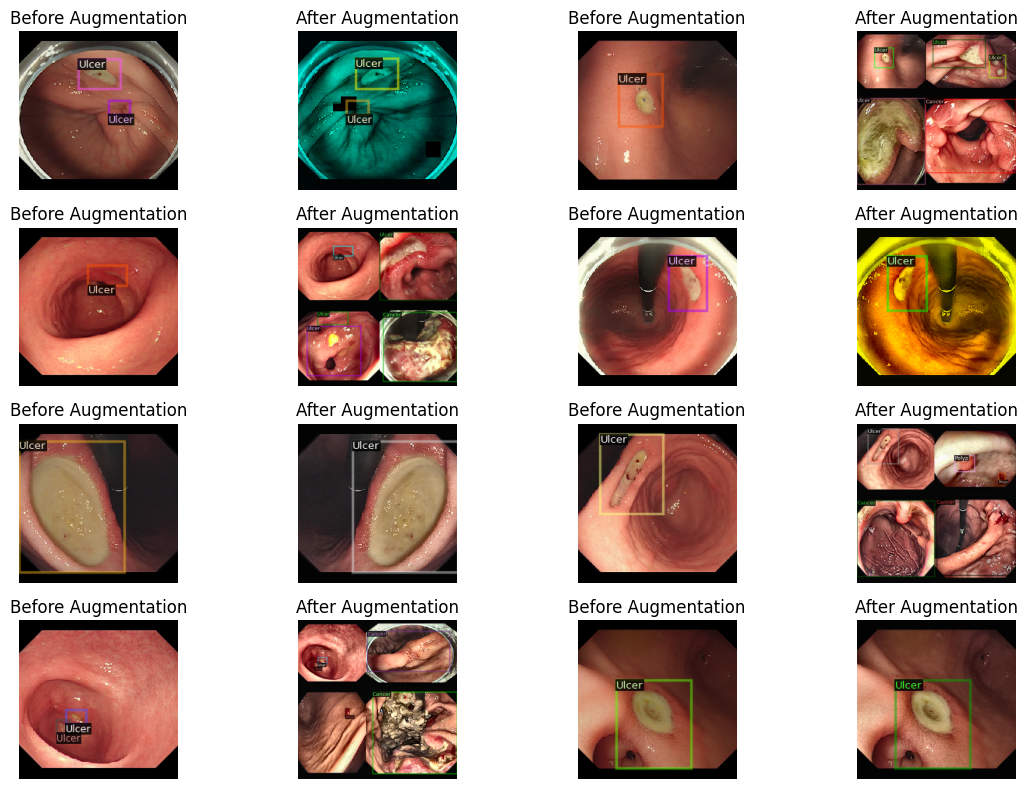

In [19]:
mapper = AlbumentationsMapper(is_train=True)

plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(4,4,2*i+1)
    plt.title('Before Augmentation')
    d = dataset_dicts[i]
    img = Image.open(d['file_name']).convert('RGB')
    img = np.array(img)
    visualizer = Visualizer(img, metadata=gastroscopy_metadata, scale=0.8)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.axis('off')

    plt.subplot(4,4, 2*i+2)
    plt.title('After Augmentation')
    mapped_d = mapper(d)
    img_arr = mapped_d['image'].cpu().permute(1,2,0).numpy()
    # img_arr[:,:,::-1] # BGR -> RGB
    # VitModel's Input Format: RGB
    visualizer = Visualizer(img_arr, metadata=gastroscopy_metadata, scale=0.8)
    target_fields = mapped_d['instances'].get_fields()
    labels = [gastroscopy_metadata.thing_classes[i] for i in target_fields['gt_classes']]

    out = visualizer.overlay_instances(
        labels = labels,
        boxes = target_fields.get('gt_boxes',None),
        masks = target_fields.get('gt_masks',None),
        keypoints = target_fields.get('gt_keypoints', None)
    )

    plt.imshow(out.get_image())
    plt.axis('off')

    del out, visualizer, labels

plt.tight_layout()
plt.show()

del mapper; clean_memory()

## 6. Lazyconfig_train_net Script
___

DefaultTrainer is limited to yacs configs.
So, for using LazyConfig file, we should use `SimpleTrainer` or `AMPTrainer`

Lazy Config is an alternative, non-intrusive config system that can be used with detectron2 or potentially any other complex projects.


In [20]:
import logging
import torch.nn as nn
from detectron2.utils import comm
from functools import partial

from omegaconf import OmegaConf
from detectron2.config import LazyConfig, instantiate
from detectron2.config import LazyCall as L
from detectron2.solver import WarmupParamScheduler
from fvcore.common.param_scheduler import MultiStepParamScheduler,  CosineParamScheduler
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.engine.defaults import create_ddp_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import MViT

from detectron2.engine import (
    AMPTrainer,
    SimpleTrainer,
    default_argument_parser,
    default_setup,
    default_writers,
    hooks,
    launch
)

from detectron2.modeling.matcher import Matcher
from detectron2.modeling.poolers import ROIPooler
from detectron2.modeling.roi_heads.box_head import FastRCNNConvFCHead
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers
from detectron2.modeling.box_regression import Box2BoxTransform

In [40]:
def setup():
  """DataLoader LazyConfig"""
  dataloader = OmegaConf.create()

  dataloader.train = L(build_detection_train_loader)(
      dataset = L(get_detection_dataset_dicts)(names='gastroscopy_train'),
      mapper=L(AlbumentationsMapper)(is_train=True),
      total_batch_size = CFG.ims_per_batch,
      num_workers = CFG.num_workers,
  )

  dataloader.test = L(build_detection_test_loader)(
      dataset = L(get_detection_dataset_dicts)(names='gastroscopy_valid'),
      mapper=L(AlbumentationsMapper)(is_train=False),
      total_batch_size = CFG.ims_per_batch,
      num_workers = CFG.num_workers,
  )

  dataloader.evaluator = L(COCOEvaluator)(
      dataset_name='gastroscopy_valid',
      tasks=("bbox",),
      output_dir=os.path.join(CFG.output_dir, 'inference')
   )

  dataloader.train.num_workers = CFG.num_workers
  dataloader.train.total_batch_size = CFG.ims_per_batch

  """Train LazyConfig"""
  train = model_zoo.get_config("common/train.py").train
  train.amp.enabled = True
  train.ddp.fp16_compression = True
  train.init_checkpoint = (
    "detectron2://ImageNetPretrained/mvitv2/MViTv2_T_in1k.pyth"
  )
  train.output_dir = CFG.output_dir

  train.max_iter = CFG.max_iter
  train.eval_period = CFG.eval_period
  train.log_period = 20
  train.checkpointer.period = CFG.eval_period
  train.device = CFG.device

  """Scheduler Config"""
  lr_multiplier = L(WarmupParamScheduler)(
    scheduler=L(CosineParamScheduler)(
        start_value = CFG.base_lr,
        end_value = CFG.base_lr / CFG.base_lr_end),
    warmup_length=CFG.warmup_iters,
    warmup_factor=CFG.warmup_factor,
    warmup_method='linear'
  )

  """Optimizer Config"""
  optimizer = model_zoo.get_config("common/optim.py").AdamW
  optimizer.params.overrides = {
    "pos_embed": {"weight_decay": 0.0},
    "rel_pos_h": {"weight_decay": 0.0},
    "rel_pos_w": {"weight_decay": 0.0},
  }
  optimizer.lr = CFG.base_lr
  optimizer.weight_decay = CFG.weight_decay

  """Model LazyConfig"""
  model = model_zoo.get_config("common/models/mask_rcnn_fpn.py").model
  model.input_format = "RGB"

  model.backbone.bottom_up = L(MViT)(
    embed_dim=96,
    depth=10,
    num_heads=1,
    last_block_indexes=(0, 2, 7, 9),
    residual_pooling=True,
    drop_path_rate=0.2,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    out_features=("scale2", "scale3", "scale4", "scale5"),
  )
  model.backbone.in_features = "${.bottom_up.out_features}"

  """Model RPN LazyConfig"""
  model.proposal_generator.in_features = ['p2', 'p3', 'p4', 'p5', 'p6']
  model.proposal_generator.anchor_generator.sizes = [[32], [64], [128], [256], [512]]
  model.proposal_generator.anchor_generator.aspect_ratios = [0.5, 1.0, 2.0]
  model.proposal_generator.anchor_generator.offset = 0.5
  model.proposal_generator.anchor_matcher.thresholds = [0.3, 0.7]
  model.proposal_generator.batch_size_per_image = 256
  model.proposal_generator.pre_nms_topk = [2000, 1000]
  model.proposal_generator.post_nms_topk = [1000, 500]

  """Model ROI LazyConfig"""
  model.roi_heads.num_classes = len(thing_classes)
  model.roi_heads.batch_size_per_image = 512
  model.roi_heads.box_in_features = ['p2', 'p3', 'p4', 'p5']
  model.roi_heads.box_pooler.output_size = 7
  model.roi_heads.box_pooler.pooler_type = 'ROIAlignV2'
  model.roi_heads.proposal_matcher.thresholds = [0.5]
  model.roi_heads.box_predictor.test_score_thresh = 0.0

  cfg = OmegaConf.create()
  cfg.model = model
  cfg.dataloader = dataloader
  cfg.train = train
  cfg.optimizer = optimizer
  cfg.lr_multiplier = lr_multiplier

  ## Delete Mask R-CNNN Part
  del cfg.model.roi_heads.mask_in_features
  del cfg.model.roi_heads.mask_pooler
  del cfg.model.roi_heads.mask_head


  return cfg


In [ ]:
def do_test(cfg, model):
    if "evaluator" in cfg.dataloader:
        ret = inference_on_dataset(
            model, instantiate(cfg.dataloader.test), instantiate(cfg.dataloader.evaluator)
        )
        print_csv_format(ret)
        return ret

In [41]:
def do_train(resume, cfg):
  model = instantiate(cfg.model)
  logger = logging.getLogger("detectron2")
  logger.info("Model:\n{}".format(model))
  model.to(cfg.train.device)

  cfg.optimizer.params.model = model
  optim = instantiate(cfg.optimizer)

  train_loader = instantiate(cfg.dataloader.train)

  model = create_ddp_model(model, **cfg.train.ddp)
  trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)

  checkpointer = DetectionCheckpointer(
        model,
        cfg.train.output_dir,
        trainer=trainer,
    )
  trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer)
            if comm.is_main_process()
            else None,
            hooks.EvalHook(cfg.train.eval_period, lambda: do_test(cfg, model)),
            hooks.PeriodicWriter(
                default_writers(cfg.train.output_dir, cfg.train.max_iter),
                period=cfg.train.log_period,
            )
            if comm.is_main_process()
            else None,
        ]
    )

  checkpointer.resume_or_load(cfg.train.init_checkpoint, resume=resume)
  if resume and checkpointer.has_checkpoint():
        start_iter = trainer.iter + 1
  else:
      start_iter = 0
  trainer.train(start_iter, cfg.train.max_iter)


### Save Lazy Config File to py

In [42]:
config_file = LazyConfig.to_py(setup())

with open(f"{CFG.output_dir}/mvit_config.py", "w") as f:
    f.write(config_file)

## 7. Training
___

In [43]:
do_train(resume=False, cfg=setup())

[02/28 05:52:33 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): MViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, element

backbone.bottom_up.scale2_norm.{bias, weight}
backbone.bottom_up.scale3_norm.{bias, weight}
backbone.bottom_up.scale4_norm.{bias, weight}
backbone.bottom_up.scale5_norm.{bias, weight}
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  head.projection.{bias, weight}
  norm.{bias, weight}


[02/28 05:52:34 d2.engine.train_loop]: Starting training from iteration 0
[02/28 05:52:46 d2.utils.events]:  eta: 0:00:50  iter: 19  total_loss: 1.79  loss_cls: 1.014  loss_box_reg: 0.009063  loss_rpn_cls: 0.6904  loss_rpn_loc: 0.04281    time: 0.5889  last_time: 0.6526  data_time: 0.0676  last_data_time: 0.0588   lr: 1.9981e-06  max_mem: 6194M
[02/28 05:53:00 d2.utils.events]:  eta: 0:00:39  iter: 39  total_loss: 0.9325  loss_cls: 0.2054  loss_box_reg: 0.02048  loss_rpn_cls: 0.6635  loss_rpn_loc: 0.04178    time: 0.6340  last_time: 0.6667  data_time: 0.0537  last_data_time: 0.0568   lr: 3.9961e-06  max_mem: 6194M
[02/28 05:53:13 d2.utils.events]:  eta: 0:00:26  iter: 59  total_loss: 0.8674  loss_cls: 0.1313  loss_box_reg: 0.08139  loss_rpn_cls: 0.601  loss_rpn_loc: 0.04461    time: 0.6477  last_time: 1.0379  data_time: 0.0739  last_data_time: 0.3384   lr: 5.9941e-06  max_mem: 6194M
[02/28 05:53:28 d2.utils.events]:  eta: 0:00:13  iter: 79  total_loss: 0.7629  loss_cls: 0.1487  loss_bo

### Visualize Train Metrics

In [44]:
metrics = pd.read_json(os.path.join(CFG.output_dir, 'metrics.json'), orient='records', lines=True)
metrics = metrics.sort_values(by=['iteration'])

print('Shape of Metrics: ',metrics.shape)
metrics.head()

Shape of Metrics:  (68, 18)


,iteration,rpn/num_neg_anchors,rpn/num_pos_anchors,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,roi_head/num_bg_samples,roi_head/num_fg_samples,data_time,eta_seconds,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,lr,rank_data_time,time,total_loss
0,0,252.5,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,254.0,2.0,0.902344,0.857143,0.0,508.5000,3.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,242.5,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,247.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,3,NaN,NaN,0.000000,0.000000,0.0,509.3125,2.6875,0.727501,NaN,0.006027,4.587233,0.704603,0.046098,48.0,0.727501,0.665751,5.351733


- #### Scheduler Graph

Scheduler Type is : WarmupCosineLR
Base Learning Rate is : 0.01
Iteration is:  100
Warmup Iteration is:  10


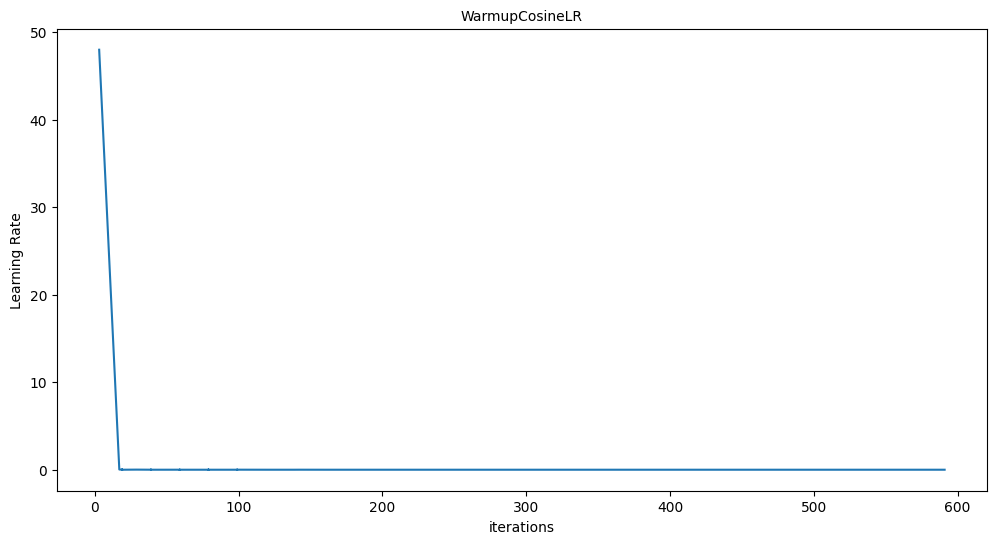

In [45]:
print('Scheduler Type is :', CFG.lr_scheduler_name)
print('Base Learning Rate is :', CFG.base_lr)
print('Iteration is: ', CFG.max_iter)
print('Warmup Iteration is: ', CFG.warmup_iters)

plt.style.use('default')
plt.figure(figsize=(12,6))
plt.title(CFG.lr_scheduler_name, size=10)

tmp = metrics[~metrics['lr'].isna()]

plt.plot(tmp['iteration'], tmp['lr'])
plt.xlabel('iterations')
plt.ylabel('Learning Rate')

plt.show()

- #### Foreground & Background Fraction in RPN & ROI

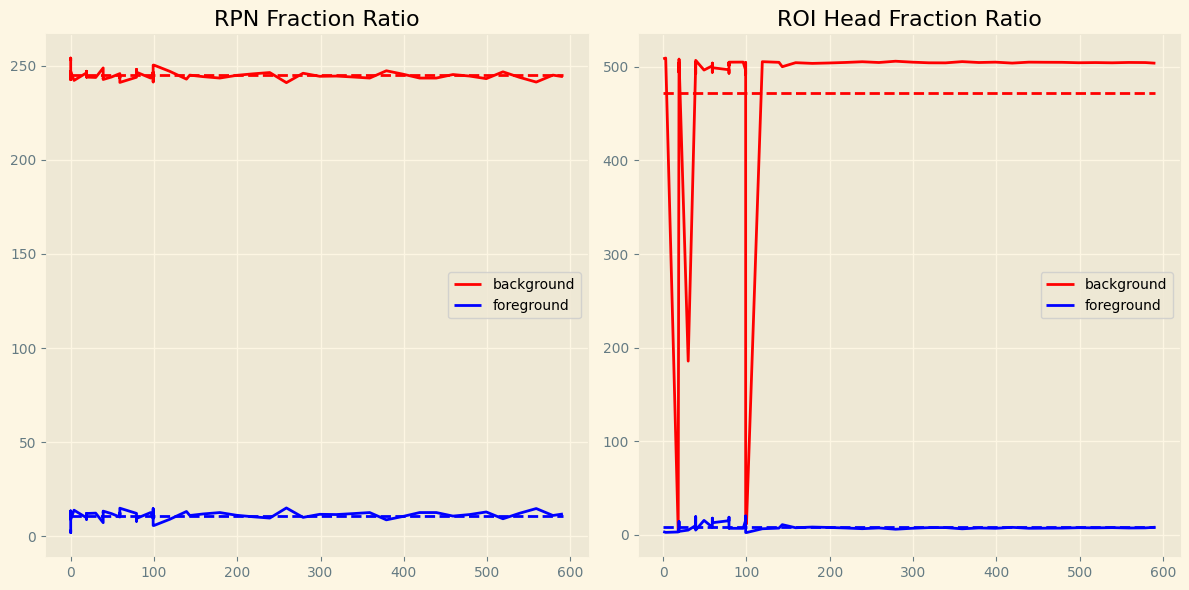

In [46]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('RPN Fraction Ratio')
tmp = metrics[~metrics['rpn/num_neg_anchors'].isna()]
tmp = tmp[~tmp['rpn/num_pos_anchors'].isna()]
plt.plot(tmp['iteration'], tmp['rpn/num_neg_anchors'], color='red', label='background')
plt.plot([0,tmp['iteration'].max()], [tmp['rpn/num_neg_anchors'].mean(), tmp['rpn/num_neg_anchors'].mean()], '--', color='red')
plt.plot(tmp['iteration'], tmp['rpn/num_pos_anchors'], color='blue', label='foreground')
plt.plot([0,tmp['iteration'].max()], [tmp['rpn/num_pos_anchors'].mean(),tmp['rpn/num_pos_anchors'].mean()], '--', color='blue')

plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.title('ROI Head Fraction Ratio')
tmp = metrics[~metrics['roi_head/num_bg_samples'].isna()]
tmp = tmp[~tmp['roi_head/num_fg_samples'].isna()]
plt.plot(tmp['iteration'], tmp['roi_head/num_bg_samples'], color='red', label='background')
plt.plot([0,tmp['iteration'].max()], [tmp['roi_head/num_bg_samples'].mean(), tmp['roi_head/num_bg_samples'].mean()], '--', color='red')
plt.plot(tmp['iteration'], tmp['roi_head/num_fg_samples'], color='blue', label='foreground')
plt.plot([0,tmp['iteration'].max()], [tmp['roi_head/num_fg_samples'].mean(),tmp['roi_head/num_fg_samples'].mean()], '--', color='blue')

plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

- #### Loss: rpn_loc, rpn_cls, box_reg, box_cls

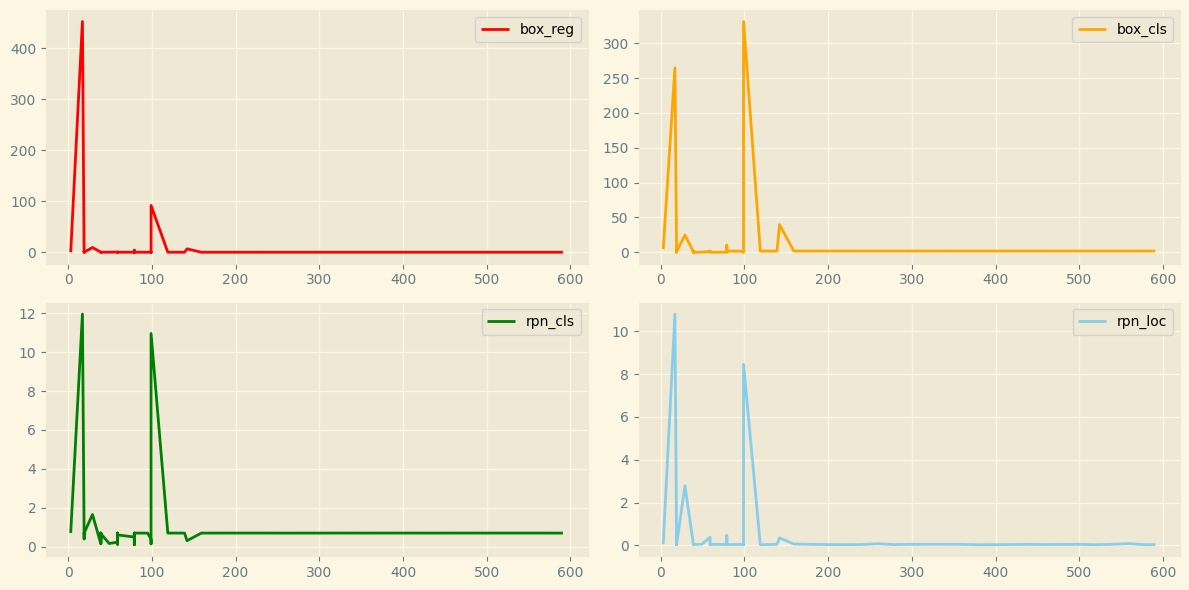

In [47]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
tmp1 = metrics[~metrics['loss_box_reg'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_box_reg'], color='red', label='box_reg')
plt.grid(True); plt.legend()

plt.subplot(2,2,2)
tmp2 = metrics[~metrics['loss_cls'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_cls'], color='orange', label='box_cls')
plt.grid(True); plt.legend()

plt.subplot(2,2,3)
tmp3 = metrics[~metrics['loss_rpn_cls'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_rpn_cls'], color='green', label='rpn_cls')
plt.grid(True); plt.legend()

plt.subplot(2,2,4)
tmp4 = metrics[~metrics['loss_rpn_loc'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_rpn_loc'], color='skyblue', label='rpn_loc')
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

### Visualize Valid Metric

In [52]:
cfg = setup()

evaluator = COCOEvaluator("gastroscopy_valid", ("bbox",), False, output_dir=os.path.join(CFG.output_dir, 'inference'))

## TorchLoader
test_loader = build_detection_test_loader(
      dataset = get_detection_dataset_dicts(names='gastroscopy_valid'),
      mapper=AlbumentationsMapper(is_train=False),
      batch_size = CFG.ims_per_batch,
      num_workers = CFG.num_workers,
      )

## Build and Load Model
model = instantiate(cfg.model)
DetectionCheckpointer(model, save_dir=CFG.output_dir).resume_or_load(
            '/content/runs/detect/model_final.pth', resume=False
        )
model.eval()

## Evaluate Metrics
result = inference_on_dataset(model, test_loader, evaluator)

[02/28 05:56:04 d2.data.build]: Removed 0 images with no usable annotations. 320 images left.
[AlbumentationsMapper] Augmentations used in inference: Compose([
  Resize(p=1.0, height=256, width=256, interpolation=1, mask_interpolation=0),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True, 'clip': False, 'max_accept_ratio': None}, keypoint_params=None, additional_targets={}, is_check_shapes=True)
[02/28 05:56:04 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/28 05:56:04 d2.data.common]: Serializing 320 elements to byte tensors and concatenating them all ...
[02/28 05:56:04 d2.data.common]: Serialized dataset takes 0.09 MiB
[02/28 05:56:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/runs/detect/model_final.pth ...
[02/28 05:56:05 d2.evaluation.evaluator]: S

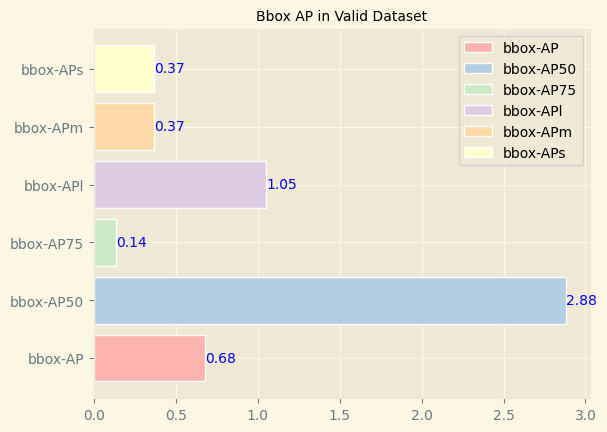

In [55]:
!pip -q install palettable
import palettable.colorbrewer.qualitative as pbq

plt.title('Bbox AP in Valid Dataset', size=10)
ax = plt.barh(y=['bbox-AP', 'bbox-AP50', 'bbox-AP75', 'bbox-APl', 'bbox-APm', 'bbox-APs'],
        width=[result['bbox']['AP'], result['bbox']['AP50'], result['bbox']['AP75'], result['bbox']['APl'],
           result['bbox']['APm'], result['bbox']['APm'],],
        color=pbq.Pastel1_7.hex_colors, edgecolor='white',
        label=['bbox-AP', 'bbox-AP50', 'bbox-AP75', 'bbox-APl', 'bbox-APm', 'bbox-APs'])

for rect in ax.patches:
    x = rect.get_width()
    y = rect.get_y() + rect.get_height()/2.0
    plt.text(x, y, f'{x:.2f}', ha='left', va='center', size=10, color='blue')

plt.legend()
plt.show()

- #### AP by class

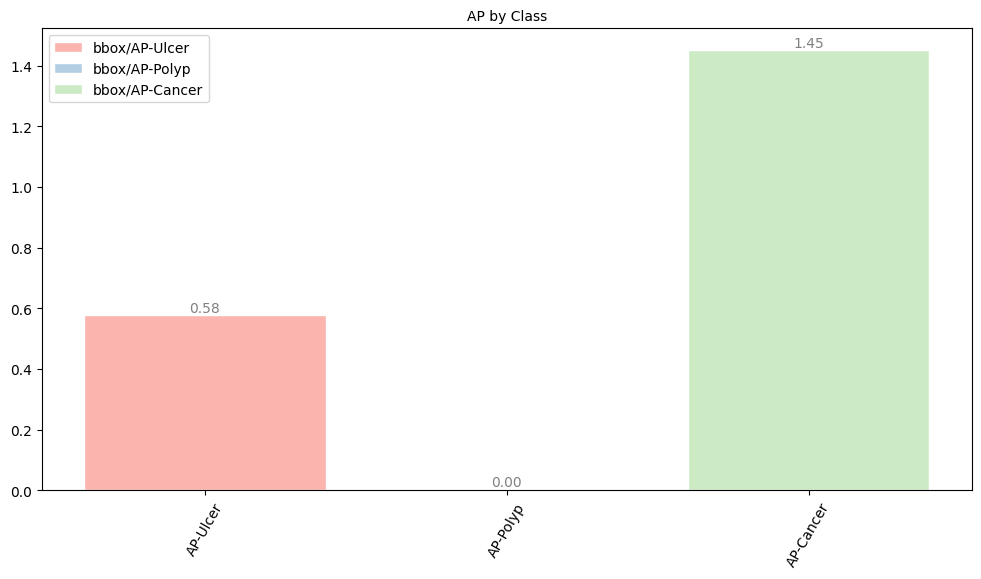

In [57]:
plt.style.use('default')
plt.figure(figsize=(12,6))

plt.title('AP by Class', size=10)
ax = plt.bar(
    x=[f'AP-{col}' for col in thing_classes],
    height=[result['bbox'][f'AP-{col}'] for col in thing_classes],
    color=pbq.Pastel1_7.hex_colors,
    edgecolor='white',
    label=[f'bbox/AP-{col}' for col in thing_classes]
)

# 막대 위에 텍스트 추가
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정


plt.legend()
plt.xticks(rotation=60)
plt.show()